In [11]:
import os
import random
import pickle
import networkx as nx
import math
import time
from time import perf_counter
import matplotlib.pyplot as plt
from itertools import combinations

In [12]:
def solution_quality(solution):
    return solution.number_of_edges()

In [13]:
def is_k_connected(G, k):
    if G.number_of_nodes() < k:
        return False
    else:
        return nx.node_connectivity(G) >= k

In [14]:
def shaking1(G, k, current_solution):
    modified_solution = current_solution.copy()

    if random.choice([True, False]):
        potential_edges_to_remove = list(modified_solution.edges())

        edge_degrees_sum = {edge: modified_solution.degree(edge[0]) + modified_solution.degree(edge[1]) for edge in potential_edges_to_remove}
        
        edges_to_remove = random.choices(potential_edges_to_remove, weights=list(edge_degrees_sum.values()), k=k)
        modified_solution.remove_edges_from(edges_to_remove)
    else:
        potential_edges = list(set(G.edges()) - set(modified_solution.edges()))
        
        edge_degrees_sum = {edge: modified_solution.degree(edge[0]) + modified_solution.degree(edge[1]) for edge in potential_edges}
        
        if potential_edges:
            edges_to_add = random.choices(potential_edges, weights=list(edge_degrees_sum.values()), k=math.floor(len(potential_edges)/2))
            modified_solution.add_edges_from(edges_to_add)
            
            for edge in edges_to_add:
                node1, node2 = edge
                
                if node1 in modified_solution.nodes() and node2 in modified_solution.nodes():
                    modified_solution.add_edge(node1, node2)

    if is_k_connected(modified_solution, k):
        return modified_solution
    else:
        return current_solution

In [15]:
def shaking2(G, k, best_solution, broj_dodavanja=20):
    H = best_solution.copy()

    grane_za_dodati = [(u, v) for u, v in G.edges() if not H.has_edge(u, v)]
    random.shuffle(grane_za_dodati)

    if len(G.edges()) - len(H.edges()) < broj_dodavanja:
        broj_dodavanja = len(G.edges()) - len(H.edges())
    broj_dodavanja = min(len(G.edges()), broj_dodavanja)
    for grana in grane_za_dodati[:broj_dodavanja]:
        H.add_edge(*grana)

    trenutne_grane = [e for e in H.edges() if e not in grane_za_dodati]
    random.shuffle(trenutne_grane)
    for u, v in trenutne_grane:
        H.remove_edge(u, v)
        if not (nx.is_k_edge_connected(H, k) and all(H.degree(node) >= k for node in H)):
            H.add_edge(u, v)

    if is_k_connected(H, k):
        return H
    else:
        return best_solution

In [16]:
def local_search(G, k):
    H = G.copy()

    grane = list(H.edges())
    random.shuffle(grane) 

    for u, v in grane:
        if H.degree(u) > k and H.degree(v) > k:
            H.remove_edge(u, v)

            if not nx.is_connected(H):
                H.add_edge(u, v)

    if is_k_connected(H, k):
        return H
    else:
        return G

In [17]:
def vns_algorithm(G, k, max_iter=5):
    if not is_k_connected(G, k):
        print("vns_algorithm: prosledjeni graf ne ispunjava uslov k povezanosti")
        return G 
    start_time = perf_counter()
    best_solution1 = G.copy()
    best_solution2 = G.copy()
    while perf_counter() - start_time < 20:
        shaken_solution = shaking1(G, k, best_solution1)
        new_solution = local_search(shaken_solution, k)
        if solution_quality(new_solution) < solution_quality(best_solution1):
            best_solution1 = new_solution.copy()

    start_time = perf_counter()
    while perf_counter() - start_time < 20:
        shaken_solution = shaking2(G, k, best_solution2)
        new_solution = local_search(shaken_solution, k)
        if solution_quality(new_solution) < solution_quality(best_solution2):
            best_solution2 = new_solution.copy()
            
    return best_solution1, best_solution2


In [18]:
def greedy_algorithm(G, k, max_iter=5):
    num_of_iter = 0;
    best_solution = G.copy()
    start_time = time.time()
    while num_of_iter < max_iter:
        new_solution = local_search(G, k)
        if solution_quality(new_solution) < solution_quality(best_solution):
            best_solution = new_solution.copy()
        num_of_iter+=1
    end_time = time.time()     
    elapsed_time = end_time - start_time
    return best_solution, elapsed_time
        

In [19]:
import matplotlib.pyplot as plt
def brute_force_min_k_connected_subgraph(G, k):
    if not nx.is_k_edge_connected(G, k):
        print("Graf nije k-povezan")
        return

    najmanji_podgraf = None
    najmanji_broj_grana = len(G.edges())

    for r in range(math.floor((G.number_of_nodes() * k) / 2), len(G.edges()) + 1):
        for edges in combinations(G.edges(), r):
            H = G.edge_subgraph(edges).copy()
            
            if all(H.degree(node) >= k for node in H) and is_k_connected(H, k):
                najmanji_podgraf = H
                najmanji_broj_grana = r
                break
                
        if najmanji_podgraf:
            break

    return najmanji_podgraf



Pocetni podgraf ima grana: 59


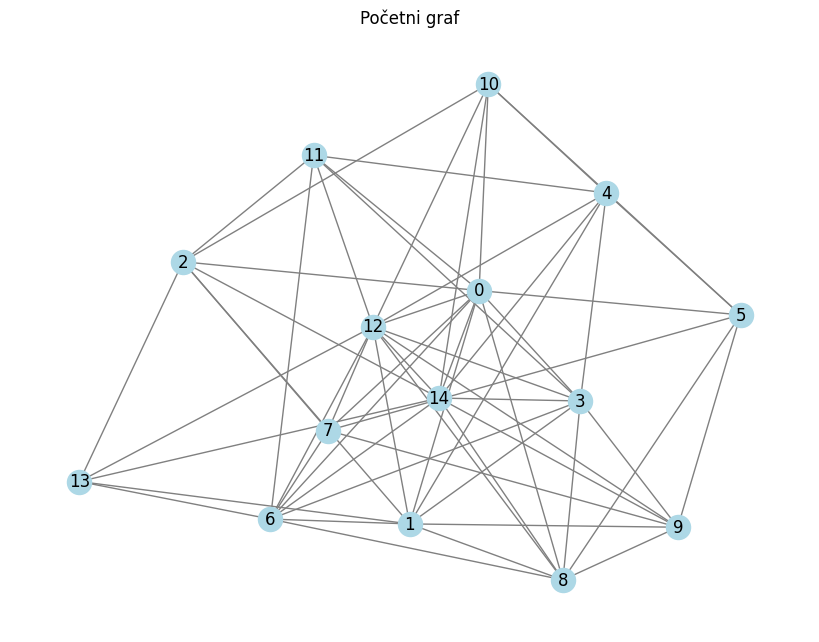

In [114]:
G = nx.erdos_renyi_graph(15, 0.5)
k = 2

print("Pocetni podgraf ima grana:", len(G.edges()))
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Početni graf")
plt.show()







In [ ]:
najmanji_podgraf_bf = brute_force_min_k_connected_subgraph(G, k)

plt.figure(figsize=(8, 6))
nx.draw(najmanji_podgraf_bf, with_labels=True, node_color='lightgreen', edge_color='gray')
plt.title("BF resenje")
plt.show()

if najmanji_podgraf_bf:
    print("Najmanji k-povezan podgraf ima grana:", len(najmanji_podgraf_bf.edges()))
else:
    print("Nije pronađen k-povezan podgraf.")

In [ ]:
k_connected_subgraph, elapsed_time = greedy_algorithm(G, k, 10)

if k_connected_subgraph:
    print("Najmanji k-povezan podgraf nadjen greedy algoritmom ima grana:", len(k_connected_subgraph.edges()))
else:
    print("Nije pronađen k-povezan podgraf.")

plt.figure(figsize=(8, 6))
nx.draw(k_connected_subgraph, with_labels=True, node_color='red', edge_color='gray')
plt.title("Greedy resenje")
plt.show()

In [ ]:
najmanji_podgraf = vns_algorithm(G,k)

plt.figure(figsize=(8, 6))
nx.draw(najmanji_podgraf, with_labels=True, node_color='lightgreen', edge_color='gray')
plt.title("VNS resenje")
plt.show()

print("Najmanji k-povezan podgraf ima grana:", len(najmanji_podgraf.edges()))

In [102]:
# G = nx.erdos_renyi_graph(12, 0.5)
# k = 2

# print("Pocetni podgraf ima grana:", len(G.edges()))
# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
# plt.title("Početni graf")
# plt.show()

In [87]:
# najmanji_podgraf_bf = brute_force_min_k_connected_subgraph(G, k)

# plt.figure(figsize=(8, 6))
# nx.draw(najmanji_podgraf_bf, with_labels=True, node_color='lightgreen', edge_color='gray')
# plt.title("BF resenje")
# plt.show()

# if najmanji_podgraf_bf:
#     print("Najmanji k-povezan podgraf ima grana:", len(najmanji_podgraf_bf.edges()))
# else:
#     print("Nije pronađen k-povezan podgraf.")

In [88]:
# k_connected_subgraph, elapsed_time = greedy_algorithm(G, k, 10)

# if k_connected_subgraph:
#     print("Najmanji k-povezan podgraf nadjen greedy algoritmom ima grana:", len(k_connected_subgraph.edges()))
# else:
#     print("Nije pronađen k-povezan podgraf.")

# plt.figure(figsize=(8, 6))
# nx.draw(k_connected_subgraph, with_labels=True, node_color='red', edge_color='gray')
# plt.title("Greedy resenje")
# plt.show()

In [89]:
# najmanji_podgraf = vns_algorithm(G,k)

# plt.figure(figsize=(8, 6))
# nx.draw(najmanji_podgraf, with_labels=True, node_color='lightgreen', edge_color='gray')
# plt.title("VNS resenje")
# plt.show()

# print("Najmanji k-povezan podgraf ima grana:", len(najmanji_podgraf.edges()))